In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import seaborn as sns

In [2]:
pbp15a = pd.read_csv("../assets/pbp-2015.csv",low_memory=False)
pbp14 = pd.read_csv("../assets/pbp-2014.csv",low_memory=False)
pbp13 = pd.read_csv("../assets/pbp-2013.csv",low_memory=False)
weather = pd.read_csv("../assets/weather.csv")
weather2 = pd.read_csv("../assets/weather2.csv")
dome = pd.read_csv("../assets/dome.csv")

In [3]:
pbp15a.GameDate = pd.to_datetime(pbp15a.GameDate)

In [4]:
#same format of date, fix
pbp14.GameDate = pd.to_datetime(pbp14.GameDate,format='%d/%m/%y')
pbp13.GameDate = pd.to_datetime(pbp13.GameDate,format='%d/%m/%y')

In [5]:
#remove null description for pbp14
pbp14 = pbp14[pbp14.Description.isnull()==False].copy(deep=True)
pbp14.reset_index(drop=True,inplace=True)

In [6]:
pbp15 = pd.concat([pbp15a,pbp14,pbp13]).copy(deep=True)

In [7]:
weather.GameDate = pd.to_datetime(weather.GameDate, format='%d/%m/%y')
weather2.GameDate = pd.to_datetime(weather2.GameDate,format='%Y-%m-%d')

In [8]:
weather = pd.concat([weather,weather2])

In [9]:
weather.drop(["city","day","location","month","state","team","year"],axis=1,inplace=True)

In [10]:
dome.GameDate = pd.to_datetime(dome.GameDate, format='%d/%m/%y')

In [11]:
dome.Dome = dome.Dome.apply(lambda x: x if x==1 else 0)

In [12]:
def kickGood(x):
    if re.search('(IS GOOD)',x):
        return 1
    else:
        return 0

In [13]:
pbp15["IsGood"]=pbp15.Description.apply(kickGood)

In [14]:
for i in pbp15.columns:
    if "Unnamed" in i:
        #checked first if there's anything inside, else drop
        #print pbp15[i].value_counts()
        #drop these columns because they are empty
        pbp15.drop(i, axis=1, inplace=True)

In [15]:
pbp15.drop(["NextScore","TeamWin","IsChallenge","IsChallengeReversed","Challenger","IsMeasurement",
            "IsTwoPointConversion","YardLineDirection","YardLineDirection","IsNoPlay","PenaltyType","PenaltyYards"],
          axis=1,inplace=True)

In [16]:
pbp15sub = pbp15.loc[:,["GameId","OffenseTeam","DefenseTeam"]].copy(deep=True)

In [17]:
d = {}

for x in pbp15sub.values.tolist():
    if pd.isnull(x[1]) == False:
        if x[0] not in d:
            d[x[0]] = x[1] + " " + x[2]

In [18]:
def fillOT(x,y,z):
    if pd.isnull(y)==True:
        for k,v in d.items():
            if x == k:
                team = v.split(" ")
                if z == team[0]:
                    return team[1]
                else:
                    return team[0]
    else:
        return y

In [19]:
pbp15["OffenseTeam"] = pbp15.apply(lambda x: fillOT(x['GameId'], x['OffenseTeam'],x['DefenseTeam']), axis=1)

In [20]:
pbp15 = pbp15.merge(weather, how="left",on=["GameDate","OffenseTeam"]).copy(deep=True)

In [21]:
pbp15 = pbp15.merge(dome, how="left",on=["GameDate","OffenseTeam"]).copy(deep=True)

In [22]:
pbp15 = pbp15.sort_values(by=["GameId","Quarter","Minute","Second"],ascending=[True,True,False,False]).copy(deep=True)

In [23]:
pbp15.reset_index(drop=True,inplace=True)

In [24]:
def initScore(x):
    if x["IsTouchdown"] == 1:
        if x["IsInterception"]==1:
            return -6
        elif x["PlayType"]=="PUNT":
            return -6
        else:
            return 6
    elif (x["PlayType"]=="FIELD GOAL") and (x["IsGood"]==1):
        return 3
    elif (x["PlayType"]=="EXTRA POINT") and (x["IsGood"]==1):
        return 1
    elif x["IsTwoPointConversionSuccessful"]==1:
        return 2
    else:
        return 0

In [25]:
pbp15["score"] = pbp15.apply(initScore, axis=1)

In [26]:
pbp15["scoreDiff"] = pbp15.apply(lambda x: 0 if (x["Quarter"]==1 and x["Minute"]==15 and x["Second"]==0) else np.nan,axis=1)

In [27]:
for x,y in enumerate(zip(pbp15["scoreDiff"].values,pbp15["OffenseTeam"])):
    if pd.isnull(y[0]):
        if y[1] == pbp15.loc[x-1,"OffenseTeam"]:
            pbp15.loc[x,"scoreDiff"]=pbp15.loc[x-1,"score"]+pbp15.loc[x-1,"scoreDiff"]
        else:
            pbp15.loc[x,"scoreDiff"]=-1*(pbp15.loc[x-1,"score"]+pbp15.loc[x-1,"scoreDiff"])

In [28]:
def intYards(x,y):
    if x==1:
        return 0
    else:
        return y

In [29]:
pbp15["Yards"] = pbp15.apply(lambda x: intYards(x['IsInterception'], x['Yards']), axis=1)

In [30]:
pbp15["lag_play"] = pbp15.apply(lambda x: 0 if (x["Quarter"]==1 and x["Minute"]==15 and x["Second"]==0) else np.nan,axis=1)

In [31]:
for x,y in enumerate(zip(pbp15["lag_play"].values,pbp15["OffenseTeam"].values)):
    if pd.isnull(y[0]):
        #if the same team, check if previous play is a pass, if it is, add 1 to previous value
        #else if same team but previous play is not a pass, we reset to 0
        if y[1] == pbp15.loc[x-1,"OffenseTeam"]:
            if pbp15.loc[x-1,"PlayType"]=="PASS":
                pbp15.loc[x,"lag_play"]=pbp15.loc[x-1,"lag_play"]+1
            else:
                pbp15.loc[x,"lag_play"]=0
        #if it's not the same team, we start with zero
        else:
            pbp15.loc[x,"lag_play"]=0

In [32]:
pbp15["agg_incomplete_drive"]=pbp15.apply(lambda x: 0 if (x["Quarter"]==1 and x["Minute"]==15 and x["Second"]==0) else np.nan,axis=1)

In [33]:
for x,y in enumerate(zip(pbp15["agg_incomplete_drive"].values,pbp15["OffenseTeam"].values)):
    if pd.isnull(y[0]):
        #if the same team, check if previous play is a pass, if it is, add 1 to previous value
        #else if same team but previous play is not a pass, we reset to 0
        if y[1] == pbp15.loc[x-1,"OffenseTeam"]:
            if (pbp15.loc[x-1,"PlayType"]=="PASS")&(pbp15.loc[x-1,"IsIncomplete"]==1):
                pbp15.loc[x,"agg_incomplete_drive"]=pbp15.loc[x-1,"agg_incomplete_drive"]+1
            else:
                pbp15.loc[x,"agg_incomplete_drive"]=pbp15.loc[x-1,"agg_incomplete_drive"]
        #if it's not the same team, we start with zero
        else:
            pbp15.loc[x,"agg_incomplete_drive"]=0

In [34]:
#if the playtype is not pass, we remove incomplete
pbp15["agg_incomplete_drive"]=pbp15.apply(lambda x: x["agg_incomplete_drive"] if x["PlayType"]=="PASS" else 0,axis=1)

In [35]:
pbp15["agg_rush_loss"]=pbp15.apply(lambda x: 0 if (x["Quarter"]==1 and x["Minute"]==15 and x["Second"]==0) else np.nan,axis=1)

In [36]:
for x,y in enumerate(zip(pbp15["agg_rush_loss"].values,pbp15["OffenseTeam"].values)):
    if pd.isnull(y[0]):
        #if the same team, check if previous play is a pass, if it is, add 1 to previous value
        #else if same team but previous play is not a pass, we reset to 0
        if y[1] == pbp15.loc[x-1,"OffenseTeam"]:
            if (pbp15.loc[x-1,"PlayType"]=="RUSH")&(pbp15.loc[x-1,"Yards"]<=0):
                pbp15.loc[x,"agg_rush_loss"]=pbp15.loc[x-1,"agg_rush_loss"]+1
            else:
                pbp15.loc[x,"agg_rush_loss"]=pbp15.loc[x-1,"agg_rush_loss"]
        #if it's not the same team, we start with zero
        else:
            pbp15.loc[x,"agg_rush_loss"]=0

In [37]:
#if the playtype is not rush, we remove agg_rush_loss
pbp15["agg_rush_loss"]=pbp15.apply(lambda x: x["agg_rush_loss"] if x["PlayType"]=="RUSH" else 0,axis=1)

In [38]:
#let's look for interceptions per game (idk if i should make this per drive, it shouldn't be too often)
pbp15["agg_ints"]=pbp15.apply(lambda x: 0 if (x["Quarter"]==1 and x["Minute"]==15 and x["Second"]==0) else np.nan,axis=1)

In [39]:
pbp15 = pbp15.sort_values(by=["GameId","agg_ints","OffenseTeam","Quarter","Minute","Second"],ascending=[True,True,True,True,False,False]).copy(deep=True)

In [40]:
pbp15.reset_index(drop=True,inplace=True)

In [41]:
for x,y in enumerate(zip(pbp15["agg_ints"].values,pbp15["GameId"].values,pbp15["OffenseTeam"].values)):
    if pd.isnull(y[0]):
        #in one game, get the interceptions
        #first look at the gameid, then if the offense team is the same
        if y[1] == pbp15.loc[x-1,"GameId"]:
            if y[2] == pbp15.loc[x-1,"OffenseTeam"]:
                if pbp15.loc[x-1,"IsInterception"]==1:
                    pbp15.loc[x,"agg_ints"]=pbp15.loc[x-1,"agg_ints"]+1
                else:
                    pbp15.loc[x,"agg_ints"]=pbp15.loc[x-1,"agg_ints"]
            #if it's not the same team, we start with zero
            else:
                pbp15.loc[x,"agg_ints"]=0
        else:
            pbp15.loc[x,"agg_ints"]=0

In [42]:
#create a copy for only the Rush Nulls
pbp15rush = pbp15[(pbp15.IsRush==1)&(pbp15.RushDirection.isnull()==True)].copy(deep=True)

In [43]:
def fillRush(x):
    if re.search('((LEFT|RIGHT).(GUARD|TACKLE|END)|(MIDDLE))',x):
        return re.search('((LEFT|RIGHT).(GUARD|TACKLE|END)|(MIDDLE))',x).group(0)
    else:
        return x

In [44]:
pbp15.loc[pbp15rush.index,"RushDirection"] = pbp15rush.Description.apply(fillRush)

In [45]:
#pbp15[(pbp15.Description.str.contains("SCRAMBLES"))]

In [46]:
#remove END of game, TIMEOUTS and Two minute warnings
pbp15.drop(pbp15[pbp15.Description.str.startswith("END")].index,inplace=True)
pbp15.drop(pbp15[pbp15.Description.str.startswith("TIMEOUT")].index,inplace=True)
pbp15.drop(pbp15[pbp15.Description.str.startswith("TWO")].index,inplace=True)

In [47]:
pbp15.loc[pbp15[pbp15.PlayType.isnull()==True].index,
          "RushDirection"] = pbp15[pbp15.PlayType.isnull()==True].Description.apply(
    lambda x:re.search('((LEFT|RIGHT).(GUARD|TACKLE|END)|(MIDDLE))',x).group(0) 
    if re.search('((LEFT|RIGHT).(GUARD|TACKLE|END)|(MIDDLE))',x) else "NA")

In [48]:
pbp15.PlayType.fillna(value="RUSH",inplace=True)
pbp15.PenaltyTeam.fillna(value="NA",inplace=True)

In [49]:
#limit to Pass, rush, punt and field goal, scramble is yet to happen
pbp15 = pbp15[(pbp15.PlayType=="PASS")|(pbp15.PlayType=="RUSH")|(pbp15.PlayType=="PUNT")|
              (pbp15.PlayType=="FIELD GOAL")].copy(deep=True)

In [50]:
#Fill out the rest of the null values which should be PassTypes and RushDirections
pbp15.fillna("NA",inplace=True)

In [51]:
pbp15 = pbp15[pbp15["PassType"].
      isin(["SHORT RIGHT","SHORT LEFT","SHORT MIDDLE","DEEP LEFT","DEEP RIGHT","DEEP MIDDLE","NA"])].copy(deep=True)

In [52]:
pbp15["IsPass"] = pbp15["IsPass"].apply(lambda x: int(x))
pbp15["IsRush"] = pbp15["IsRush"].apply(lambda x: int(x))

In [53]:
def getTarget(x):
    if x["IsRush"]==1:
        #get the rush direction
        return x["PlayType"] + " " + x["RushDirection"]
    elif x["IsPass"]==1:
        return x["PlayType"] + " " + x["PassType"]
    else:
        return x["PlayType"]

In [54]:
pbp15["specific"] = pbp15.apply(getTarget,axis=1)

In [55]:
#drop the ones without direction
pbp15.drop(pbp15[pbp15.specific=="PASS NA"].index,inplace=True)
pbp15.drop(pbp15[pbp15.specific=="RUSH NA"].index,inplace=True)
pbp15.drop(pbp15[pbp15.specific=="RUSH"].index,inplace=True)

In [56]:
pbp15 = pbp15.sort_values(by=["GameId","rain","OffenseTeam","Quarter","Minute","Second"],ascending=[True,True,True,True,False,False])
pbp15.reset_index(drop=True,inplace=True)

In [57]:
pbp15["snow"] = pbp15["snow"].apply(lambda x: np.nan if x=="NA" else x)
pbp15["rain"] = pbp15["rain"].apply(lambda x: np.nan if x=="NA" else x)

In [58]:
pbp15["Dome"] = pbp15["Dome"].apply(lambda x: np.nan if x=="NA" else x)

In [59]:
pbp15.ffill(inplace=True)

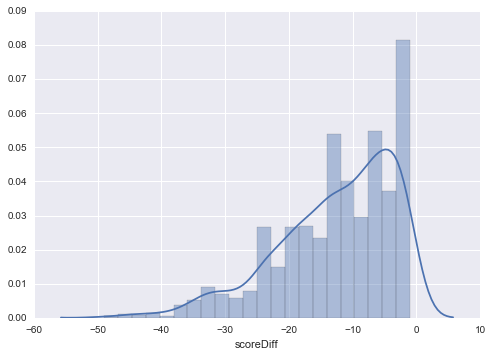

In [60]:
sns.distplot(pbp15[(pbp15["Quarter"]==4)&(pbp15["Minute"]==2)&(pbp15["scoreDiff"]<0)].scoreDiff)

In [61]:
pbp15[(pbp15["Quarter"]==4)&(pbp15["Minute"]==2)&(pbp15["scoreDiff"]<0)].scoreDiff.median()

-11.0

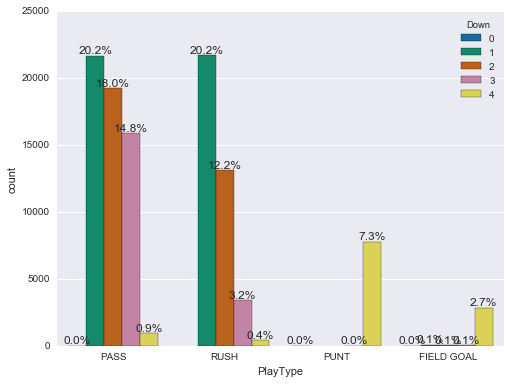

In [62]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x="PlayType", data=pbp15, hue="Down",palette="colorblind")

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/len(pbp15)), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

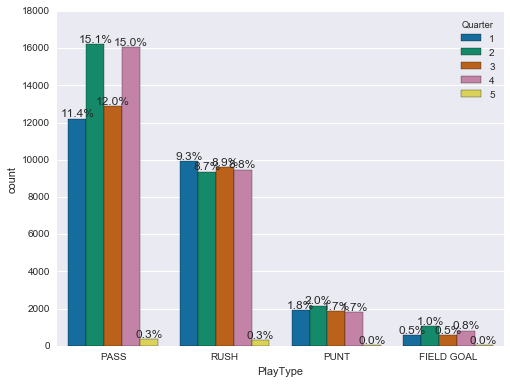

In [63]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x="PlayType", data=pbp15, hue="Quarter",palette="colorblind")

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/len(pbp15)), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

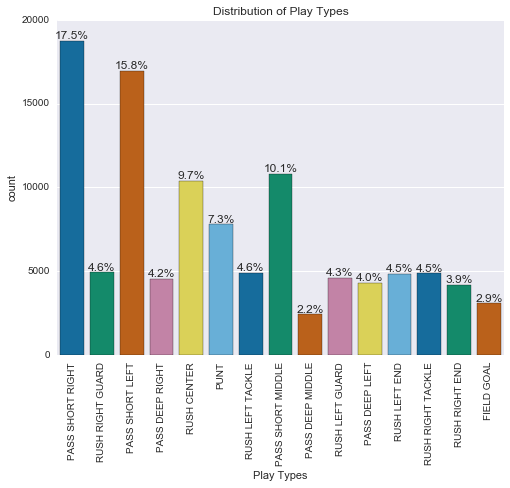

In [64]:
#baseline for specific play 
plt.figure(figsize=(8,6))
ax = sns.countplot(x="specific", data=pbp15,palette="colorblind")
plt.title('Distribution of Play Types')
plt.xlabel('Play Types')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/len(pbp15)), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
    
for item in ax.get_xticklabels():
    item.set_rotation(90)

In [65]:
def getDirection(x):
    if x.split(" ")[0]=="PASS":
        if "LEFT" in x:
            return "PASS LEFT"
        elif "RIGHT" in x:
            return "PASS RIGHT"
        else:
            return "PASS MIDDLE"
    elif x.split(" ")[0]=="RUSH":
        if "LEFT" in x:
            return "RUSH LEFT"
        elif "RIGHT" in x:
            return "RUSH RIGHT"
        else:
            return "RUSH CENTER"
    elif x.split(" ")[0]=="FIELD":
        return "FIELD GOAL"
    else:
        return "PUNT"

In [66]:
pbp15["direction"] = pbp15["specific"].apply(getDirection)

In [67]:
def getDirection2(x):
    if "LEFT" in x:
        return "LEFT"
    elif "RIGHT" in x:
        return "RIGHT"
    elif "MIDDLE" in x:
        return "MIDDLE"
    elif "CENTER" in x:
        return "CENTER"
    else:
        return "OTHER"

In [68]:
pbp15["direc_only"] = pbp15["specific"].apply(getDirection2)

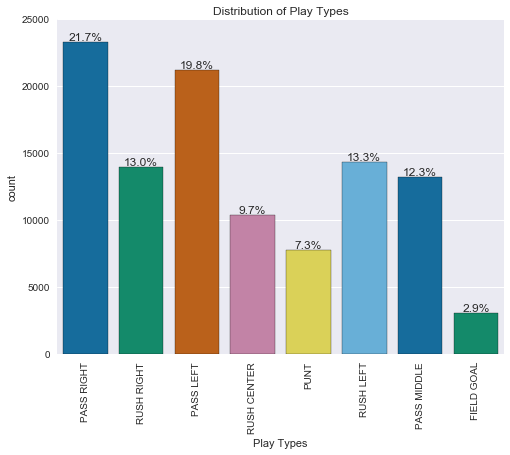

In [69]:
#baseline for Play + Direction
plt.figure(figsize=(8,6))
ax = sns.countplot(x="direction", data=pbp15,palette="colorblind")
plt.title('Distribution of Play Types')
plt.xlabel('Play Types')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/len(pbp15)), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
    
for item in ax.get_xticklabels():
    item.set_rotation(90)

In [70]:
def getShortDeep(x):
    if x.split(" ")[0]=="PASS":
        if "SHORT" in x:
            return "PASS SHORT"
        else:
            return "PASS DEEP"
    elif x.split(" ")[0]=="RUSH":
        return "RUSH"
    elif x.split(" ")[0]=="FIELD":
        return "FIELD GOAL"
    else:
        return "PUNT"

In [71]:
pbp15["shortDeep"] = pbp15["specific"].apply(getShortDeep)

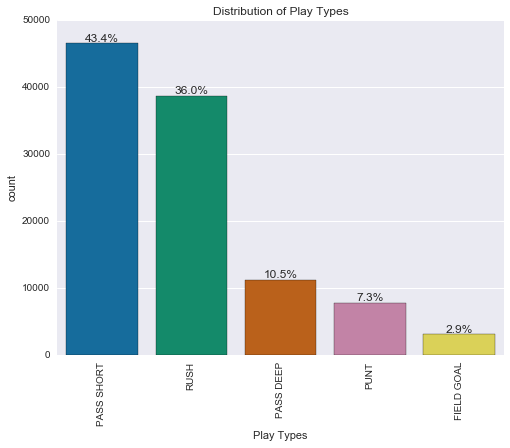

In [72]:
#baseline for specific play 
plt.figure(figsize=(8,6))
ax = sns.countplot(x="shortDeep", data=pbp15,palette="colorblind")
plt.title('Distribution of Play Types')
plt.xlabel('Play Types')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/len(pbp15)), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
    
for item in ax.get_xticklabels():
    item.set_rotation(90)

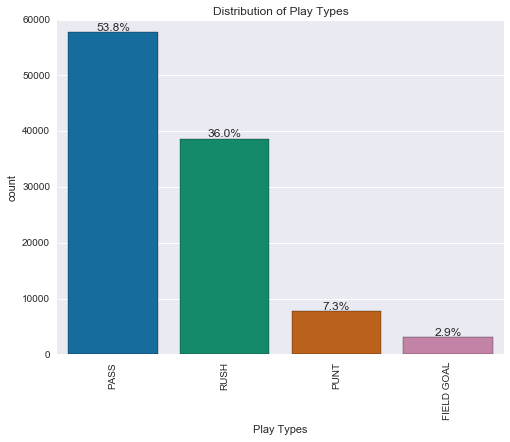

In [73]:
#baseline for specific play 
plt.figure(figsize=(8,6))
ax = sns.countplot(x="PlayType", data=pbp15,palette="colorblind")
plt.title('Distribution of Play Types')
plt.xlabel('Play Types')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/len(pbp15)), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
    
for item in ax.get_xticklabels():
    item.set_rotation(90)

In [74]:
addInfo = pd.read_csv("../assets/hqc.csv")

In [75]:
pbp15 = pbp15.merge(addInfo,how="left",on="OffenseTeam").copy(deep=True)

In [76]:
comb = pbp15.copy(deep=True)
comb = comb[comb["Quarter"]<=4].copy(deep=True)
comb = comb[comb["Minute"]>=2].copy(deep=True)

In [77]:
pbp15.to_csv("../assets/pbp.csv")

# Model

In [78]:
from sklearn.cross_validation import train_test_split,cross_val_score,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler,label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

In [79]:
random_state = np.random.RandomState(0)

In [80]:
def score(model, name, myX,myy):
    s = cross_val_score(model, myX, myy, cv=cv)
    print "{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3))

In [81]:
def fitAndPrint(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print "Accuracy Score: %s"%(accuracy_score(y_test,y_pred))
    print confusion_matrix(y_test,y_pred)
    print classification_report(y_test,y_pred)

Start with the all the data that we have

In [82]:
le = LabelEncoder()

In [83]:
pbp15["OT"] = le.fit_transform(pbp15["OffenseTeam"].values)
pbp15["DT"] = le.transform(pbp15["DefenseTeam"].values)
pbp15["Form"] = le.fit_transform(pbp15["Formation"].values)

In [84]:
#try substituting yardline to YardLineFixed
initList = [u'Quarter', u'Minute', u'Second',
       u'Down', u'ToGo', u'YardLine', u'Yards', u'SeriesFirstDown',
       u'scoreDiff', u'OT', u'DT', u'Form',u'agg_incomplete_drive',u'lag_play',u'agg_rush_loss',
            u'snow',u'rain',u'agg_ints',u'HC',u'OC',u'QB',u'Dome']

In [85]:
#Classify to pass, rush, punt or fg
X=pbp15[initList]
y=pbp15["PlayType"]

In [86]:
cv = StratifiedKFold(y, n_folds=5,shuffle=True)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.5,random_state=random_state)

In [88]:
#initialize our model
rf = RandomForestClassifier()

In [89]:
score(rf,"Random Forest",X,y)

Random Forest Score:	0.846 ± 0.003


In [90]:
gb = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8)
score(gb,"GB",X,y)

GB Score:	0.867 ± 0.002


In [91]:
gb2 = GradientBoostingClassifier()
score(gb2,"Gradient Boosting General",X,y)

Gradient Boosting General Score:	0.864 ± 0.002


In [92]:
#we can see that gb has a higher score that random forest, but let's fit random forest and take a look at the
#feature importances (without consideration of learning from weak classes)
fitAndPrint(rf)

Accuracy Score: 0.845019207101
[[ 1504     1     0     0]
 [    2 25792    23  2993]
 [    0     4  3843     1]
 [    3  5275     9 14176]]
             precision    recall  f1-score   support

 FIELD GOAL       1.00      1.00      1.00      1505
       PASS       0.83      0.90      0.86     28810
       PUNT       0.99      1.00      1.00      3848
       RUSH       0.83      0.73      0.77     19463

avg / total       0.84      0.85      0.84     53626



In [93]:
for a,b in zip(rf.feature_importances_,initList):
    print a,b

0.0198736168773 Quarter
0.038203641774 Minute
0.0459647025672 Second
0.140714948433 Down
0.0409660026089 ToGo
0.0642366963585 YardLine
0.150793190535 Yards
0.0205402449904 SeriesFirstDown
0.0444880501842 scoreDiff
0.0373885399935 OT
0.0399664201021 DT
0.165921834103 Form
0.076134970429 agg_incomplete_drive
0.016598818093 lag_play
0.046840343036 agg_rush_loss
0.00344684813068 snow
0.00864751537494 rain
0.0118217053046 agg_ints
0.00787046100766 HC
0.00497684237278 OC
0.00838084577896 QB
0.00622376194584 Dome


In [94]:
fitAndPrint(gb)

Accuracy Score: 0.866501323985
[[ 1504     1     0     0]
 [    0 25716    19  3075]
 [    0     4  3842     2]
 [    0  4052     6 15405]]
             precision    recall  f1-score   support

 FIELD GOAL       1.00      1.00      1.00      1505
       PASS       0.86      0.89      0.88     28810
       PUNT       0.99      1.00      1.00      3848
       RUSH       0.83      0.79      0.81     19463

avg / total       0.87      0.87      0.87     53626



In [96]:
#for visualizations in Tableau
predictions = gb.predict_proba(X)

In [102]:
#get the probability of each play
proba = [max(each) for each in predictions]

In [139]:
df = X.copy(deep=True)
df["y_proba"] = proba

In [140]:
df = df.merge(pbp15[["OffenseTeam","DefenseTeam","GameId","PlayType","score"]], how="left",left_index=True, right_index=True).copy(deep=True)

In [108]:
#try to optimize our model
param_test1 = {'n_estimators':range(20,81,10)}
gs = GridSearchCV(gb,param_grid = param_test1,n_jobs=-1,iid=False, cv=5)

In [109]:
score(gb,"GB with GS",X,y)

GB with GS Score:	0.867 ± 0.003


In [110]:
fitAndPrint(gs)

Accuracy Score: 0.866557266997
[[ 1504     1     0     0]
 [    0 25691    18  3101]
 [    0     4  3843     1]
 [    0  4023     8 15432]]
             precision    recall  f1-score   support

 FIELD GOAL       1.00      1.00      1.00      1505
       PASS       0.86      0.89      0.88     28810
       PUNT       0.99      1.00      1.00      3848
       RUSH       0.83      0.79      0.81     19463

avg / total       0.87      0.87      0.87     53626



In [128]:
X=pbp15[initList]
y=pbp15["shortDeep"]

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.5,random_state=random_state)

In [130]:
fitAndPrint(gb)

Accuracy Score: 0.778409726625
[[ 1546     0     0     0     1]
 [    0  1700  3619     7   273]
 [    0  1083 18891     5  3271]
 [    0     0     2  3918     3]
 [    0   348  3266     5 15688]]
             precision    recall  f1-score   support

 FIELD GOAL       1.00      1.00      1.00      1547
  PASS DEEP       0.54      0.30      0.39      5599
 PASS SHORT       0.73      0.81      0.77     23250
       PUNT       1.00      1.00      1.00      3923
       RUSH       0.82      0.81      0.81     19307

avg / total       0.77      0.78      0.77     53626



In [157]:
fitAndPrint(gs)

Accuracy Score: 0.777346809384
[[ 1546     1     0     0     0]
 [    0  1614  3718     6   261]
 [    0  1014 19003     2  3231]
 [    0     1     0  3919     3]
 [    0   325  3373     5 15604]]
             precision    recall  f1-score   support

 FIELD GOAL       1.00      1.00      1.00      1547
  PASS DEEP       0.55      0.29      0.38      5599
 PASS SHORT       0.73      0.82      0.77     23250
       PUNT       1.00      1.00      1.00      3923
       RUSH       0.82      0.81      0.81     19307

avg / total       0.77      0.78      0.77     53626



In [178]:
X=pbp15[initList]
y=pbp15["direction"]

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.5,random_state=random_state)

In [180]:
fitAndPrint(gb)

Accuracy Score: 0.405064707418
[[1513    0    0    0    0    1    0    0]
 [   0 3447  748 5193    4  263  540  425]
 [   0 2096  734 3304    6  132  208  163]
 [   1 3471  749 5988   11  287  609  534]
 [   0    2    1    0 3911    0    0    0]
 [   0  374   40  713    3 1401 1319 1367]
 [   1  477   80  995    1  913 2441 2251]
 [   0  511   68  900    7  910 2226 2287]]
             precision    recall  f1-score   support

 FIELD GOAL       1.00      1.00      1.00      1514
  PASS LEFT       0.33      0.32      0.33     10620
PASS MIDDLE       0.30      0.11      0.16      6643
 PASS RIGHT       0.35      0.51      0.42     11650
       PUNT       0.99      1.00      1.00      3914
RUSH CENTER       0.36      0.27      0.31      5217
  RUSH LEFT       0.33      0.34      0.34      7159
 RUSH RIGHT       0.33      0.33      0.33      6909

avg / total       0.40      0.41      0.39     53626



In [191]:
fitAndPrint(gs)

Accuracy Score: 0.403815313467
[[1513    0    0    0    0    1    0    0]
 [   0 3165  589 5654   14  248  542  408]
 [   0 1999  604 3552   10  112  211  155]
 [   1 3255  601 6398   14  268  611  502]
 [   0    0    0    4 3910    0    0    0]
 [   0  374   46  745    3 1345 1381 1323]
 [   0  495   72 1065    1  842 2503 2181]
 [   0  470   64  993    8  821 2336 2217]]
             precision    recall  f1-score   support

 FIELD GOAL       1.00      1.00      1.00      1514
  PASS LEFT       0.32      0.30      0.31     10620
PASS MIDDLE       0.31      0.09      0.14      6643
 PASS RIGHT       0.35      0.55      0.43     11650
       PUNT       0.99      1.00      0.99      3914
RUSH CENTER       0.37      0.26      0.30      5217
  RUSH LEFT       0.33      0.35      0.34      7159
 RUSH RIGHT       0.33      0.32      0.32      6909

avg / total       0.40      0.40      0.39     53626



In [ ]:
###This was done after the initial tests of just pass,rush,fg,punt
#Trying to see if we can determine which features were predictive of passes but seems like the accuracy
#is the same as just fitting the model directly to predict the classes with direction

In [ ]:
comb["OT"] = le.fit_transform(comb["OffenseTeam"].values)
comb["DT"] = le.transform(comb["DefenseTeam"].values)
comb["Form"] = le.fit_transform(comb["Formation"].values)

In [ ]:
X=comb[initList]
y=comb["PlayType"]

In [406]:
#let's test if we can pull out the passes and predict the direction
test_pred = gb.predict(X_test)
df = X_test.copy(deep=True)
df["y_pred"] = test_pred

In [407]:
df = df.merge(pbp15[["direc_only"]], how="left",left_index=True, right_index=True).copy(deep=True)

In [408]:
passdf = df[df["y_pred"]=="PASS"]

In [409]:
xs = passdf[initList]
ys = passdf["direc_only"]

In [410]:
X_train, X_test, y_train, y_test = train_test_split(xs,ys,test_size=.3,random_state=random_state)

In [411]:
#38% accuracy only
fitAndPrint(gb)

Accuracy Score: 0.382201300157
[[   2  129    6    0  196]
 [   2 1319  193    0 1792]
 [   1  713  176    0  936]
 [   0    0    0    0    1]
 [   3 1345  195    0 1913]]
             precision    recall  f1-score   support

     CENTER       0.25      0.01      0.01       333
       LEFT       0.38      0.40      0.39      3306
     MIDDLE       0.31      0.10      0.15      1826
      OTHER       0.00      0.00      0.00         1
      RIGHT       0.40      0.55      0.46      3456

avg / total       0.37      0.38      0.35      8922



### This part is just for visualization in Tableau

In [166]:
yardline = df[df["GameId"]==2015091300][["score","y_proba","scoreDiff","Yards","YardLine","PlayType","OffenseTeam","DefenseTeam","Quarter","Minute","Second"]].copy(deep=True)

In [260]:
randlist = [rand.randrange(1,51,1) for _ in range (168)]

In [167]:
yardline["constant"] = .75

In [168]:
yardline["Minute"] = yardline["Minute"].apply(lambda x: x*60)

In [169]:
yardline["totalsec"] = yardline.apply(lambda x: x["Minute"]+x["Second"],axis=1)

In [183]:
def getSecs(x):
    if x["Quarter"] == 1:
        return 900 - x["totalsec"]
    elif x["Quarter"] == 2:
        return 1800 - x["totalsec"]
    elif x["Quarter"] ==3:
        return 2700 - x["totalsec"]
    else:
        return 3600 - x["totalsec"]

In [184]:
yardline["secondspassed"] = yardline.apply(getSecs,axis=1)

In [185]:
yardline.sort_values(by=["Quarter","Minute","Second"],ascending=[True,False,False],inplace=True)

In [189]:
yardline["YardLine"]=yardline.apply(lambda x: x["YardLine"] if x["OffenseTeam"]=="CHI" else 100-x["YardLine"],axis=1)

In [190]:
yardline.to_csv("../assets/yardline.csv")